In [1]:
import tempfile
from collections import Counter
from itertools import product, zip_longest
import scipy
import anndata as ad
import matplotlib.pyplot as plt
# import mudata as md
from bar_nick_utils import plot_torch_normal, add_spatial_data_to_prot, preprocess_protein, preprocess_rna
from anndata import AnnData
# import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch
# ignore warnings
import warnings
import pandas as pd
import numpy    as np
import os
import tempfile
import torch.functional as F
from scipy.sparse import issparse
from scipy.stats import zscore
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import scvi
from scvi.model import SCVI
from scvi.train import TrainingPlan
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from datetime import datetime

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plot_flag = False                                        
device = "cuda:0" if torch.cuda.is_available() else "cpu"
pd.set_option("display.max_columns", 10)
pd.set_option("display.max_rows", 10)
warnings.filterwarnings("ignore")
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
np.set_printoptions(threshold=100) 
np.random.seed(0)
plot_flag = False


/home/barroz/miniconda3/envs/scvi_1.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
save_dir = 'data/totalVI'
# adata = scvi.data.pbmcs_10x_cite_seq(save_path=save_dir)
adata = scvi.data.spleen_lymph_cite_seq(save_path=save_dir)
adata.obsm['protein_expression'].shape
# adata.write('data/totalVI/spleen_lymph_cite_seq.h5ad')

INFO     File data/totalVI/sln_111.h5ad already downloaded                                                         
INFO     File data/totalVI/sln_208.h5ad already downloaded                                                         


(30474, 110)

In [3]:
# sc.read_10x_h5('/home/barroz/Downloads/10k_PBMCs_TotalSeq_B_3p_raw_feature_bc_matrix.h5')

In [4]:
adata.obsm['protein_expression'].shape
adata.obs['cell_types'] = pd.Categorical(adata.obs['cell_types'])
assert len(set(adata.obs['batch']))!=1
adata_prot = AnnData(adata.obsm['protein_expression'])
# remove protein_expression from adatan/
adata_rna = adata.copy()
adata_rna.obsm.pop('protein_expression')
# add all obs and var to adata_prot
adata_prot.obs = adata_rna.obs
# remove n_genes and percent_mito from adata_prot
adata_prot.obs = adata_prot.obs.drop(columns=['n_genes', 'percent_mito'])
# take only the first batch from adata_prot and adata_rna
# first_batch = adata_prot.obs['batch'][0]
# take the largest batch 
larget_batch = adata_prot.obs['batch'].value_counts().idxmax()
# sc.pl.umap(adata_prot_subset, color="batch",neighbors_key='original_neighbors',title='Original data minor cell types')


In [5]:
adata_prot = adata_prot[adata_prot.obs['batch'] == larget_batch]
adata_rna = adata_rna[adata_rna.obs['batch'] == larget_batch]
adata_rna = preprocess_rna(adata,adata_rna)
adata_prot = preprocess_protein(adata_prot)

In [6]:
rna_archetype_vecs = pd.read_csv('data/rna_weights.csv',index_col = 0)
protein_archetype_vecs = pd.read_csv('data/protein_weights.csv',index_col = 0)
rna_archetype_vecs.index = adata_rna.obs.index
protein_archetype_vecs.index = adata_prot.obs.index
protein_mapping = ['Red blood cells', 'T cells-2', 'Plasmacytoid dendritic cells','Natural killer T cells', 'Natural killer cells', 'Neutrophils', 'Dendritic cells', 'Regulatory T cells', 'Monocytes', 'Macrophages', 'Conventional dendritic cells', 'B cells', 'T cells-1' ]
rna_archetype_vecs.columns = protein_mapping
gene_mapping = ['Monocytes', 'T cells-2', 'T cells-1', 'Macrophages', 'Neutrophils', 'Red blood cells', 'Natural killer cells', 'Conventional dendritic cells', 'Regulatory T cells', 'Dendritic cells', 'Natural killer T cells','Plasmacytoid dendritic cells', 'B cells' ]
protein_archetype_vecs.columns = gene_mapping
types_to_pop = ['Plasmacytoid dendritic cells', 'Plasmacytoid dendritic cells','Conventional dendritic cells','Red blood cells','Dendritic cells','Monocytes','Natural killer T cells','Natural killer cells','Neutrophils']
# filter out the types that are not in the mapping form the mapping


gene_argsort_indices = [i for i, _ in sorted(enumerate(gene_mapping), key=lambda x: x[1])]
protein_argsort_indices = [i for i, _ in sorted(enumerate(protein_mapping), key=lambda x: x[1])]
rna_archetype_vecs = rna_archetype_vecs.iloc[:,gene_argsort_indices]
rna_archetype_vecs = rna_archetype_vecs.drop(columns=types_to_pop)
protein_archetype_vecs = protein_archetype_vecs.iloc[:,protein_argsort_indices]
protein_archetype_vecs = protein_archetype_vecs.drop(columns=types_to_pop)
adata_rna.obsm['archetype_vec'] = rna_archetype_vecs
adata_prot.obsm['archetype_vec'] = protein_archetype_vecs

In [7]:
sample_size = min(len(adata_prot), len(adata_rna), 2000)
adata_prot_subset = sc.pp.subsample(adata_prot, n_obs=sample_size,copy=    True)
adata_rna_subset = sc.pp.subsample(adata_rna, n_obs=sample_size,copy=    True)
del adata_prot, adata_rna

In [8]:
# plot protein expression pca and rna expression pca
# sc.pp.pca(adata_prot)
# sc.pp.pca(adata_rna)
# sc.pl.pca(adata_prot)
# sc.pl.pca(adata_rna)
# take a subset of the data using scanpy to a new anndata object


In [9]:
cell_type_mapping = {
    "Activated CD4 T": "CD4 T",
    "B1 B": "B cells",
    "CD122+ CD8 T": "CD8 T",
    "CD4 T": "CD4 T",
    "CD8 T": "CD8 T",
    "Erythrocytes": "RBC",
    "GD T": "T cells",
    "ICOS-high Tregs": "CD4 T",
    "Ifit3-high B": "B cells",
    "Ifit3-high CD4 T": "CD4 T",
    "Ifit3-high CD8 T": "CD8 T",
    "Ly6-high mono": "Monocytes",
    "Ly6-low mono": "Monocytes",
    "MZ B": "B cells",
    "MZ/Marco-high macrophages": "Macrophages",
    "Mature B": "B cells",
    "Migratory DCs": "cDCs",
    "NK": "NK",
    "NKT": "T cells",
    "Neutrophils": "Neutrophils",
    "Plasma B": "B cells",
    "Red-pulp macrophages": "Macrophages",
    "Transitional B": "B cells",
    "Tregs": "Treg",
    "cDC1s": "cDCs",
    "cDC2s": "cDCs",
    "pDCs": "pDCs",
}
# Map the specific cell types to major cell types and add as a new column in obs
adata_rna_subset.obs['major_cell_types'] = pd.Categorical( adata_rna_subset.obs['cell_types'].map(cell_type_mapping))
adata_prot_subset.obs['major_cell_types'] =pd.Categorical(  adata_rna_subset.obs['cell_types'].map(cell_type_mapping))
# sort by major cell types
adata_rna_subset = adata_rna_subset[adata_rna_subset.obs['major_cell_types'].sort_values().index]
adata_prot_subset = adata_prot_subset[adata_prot_subset.obs['major_cell_types'].sort_values().index]
major_to_minor_dict ={}
# from major to minor dict
for k,v in cell_type_mapping.items():
    if v not in major_to_minor_dict:
        major_to_minor_dict[v] = [k]
    else:
        major_to_minor_dict[v].append(k)
    
# [len(x) for x in major_to_minor_dict.values()]

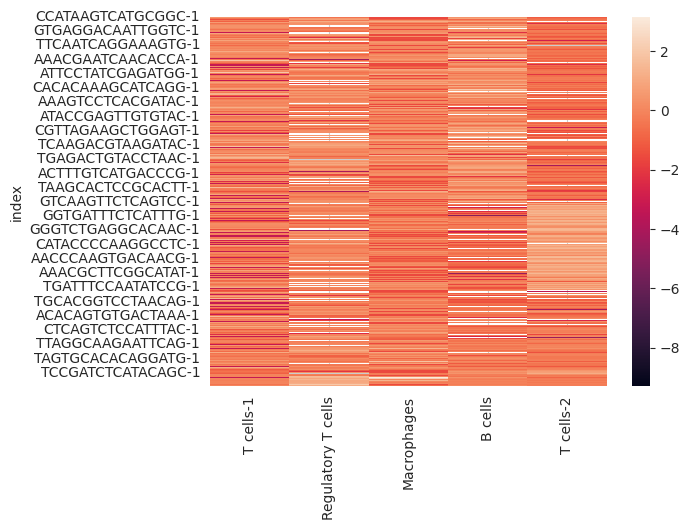

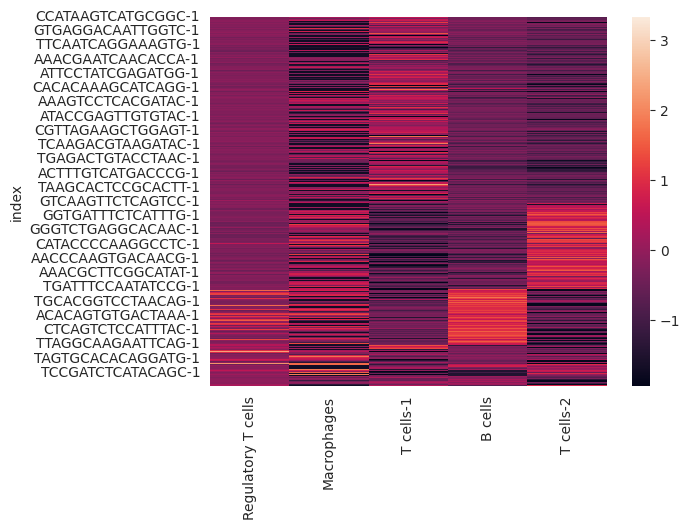

In [10]:

rna_archetype_vecs = adata_rna_subset.obsm['archetype_vec'] 
protein_archetype_vecs = adata_prot_subset.obsm['archetype_vec']
rna_archetype_vecs = (rna_archetype_vecs -    rna_archetype_vecs.mean()) / rna_archetype_vecs.std()
protein_archetype_vecs = (protein_archetype_vecs - protein_archetype_vecs.mean()) / protein_archetype_vecs.std()
sns.heatmap(np.log1p(rna_archetype_vecs))
plt.show()
sns.heatmap(np.log1p(protein_archetype_vecs))
plt.show()

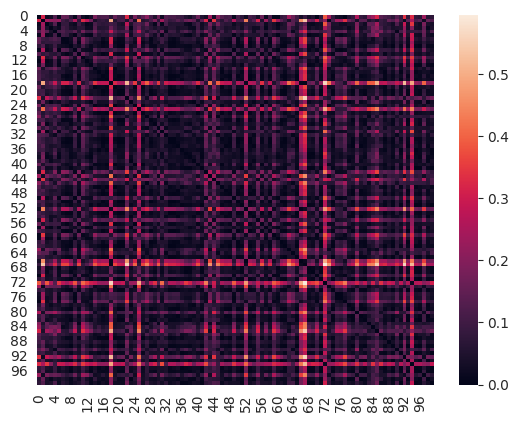

Warning, the matching cells are sorted, make sure you are not comparing the same cells RNA to RAN


In [11]:
# add archetype_distances to adata_rna_subset
adata_rna_subset.obs['index_col'] = np.arange(adata_rna_subset.shape[0])
adata_prot_subset.obs['index_col'] = np.arange(adata_prot_subset.shape[0])
if 'archetype_vec' not in adata_rna_subset.obsm.keys():
    raise Exception('archetype_vec not in adata_rna_subset.obsm.keys()')
# set the archtyeps distances from rna to protein

# set the archetype distances to the rna adata
# TODO I do RNA to RNA DISTANCES!!! should repalce this with RNA to protein distances!!!!
archetype_distances = scipy.spatial.distance.cdist(adata_rna_subset.obsm['archetype_vec'].values,
                                                   adata_rna_subset.obsm['archetype_vec'].values,metric='cosine')
                                                   # adata_prot_subset.obsm['archetype_vec'].values,metric='cosine')
adata_rna_subset.obsm['archetype_distances'] = archetype_distances
matching_cells = np.argmin(archetype_distances,axis=1)
adata_prot_subset = adata_prot_subset[matching_cells] # this make sure that the cells are aligned!
# adata_rna_subset.obs['matching_protein_cells'] = matching_cells
sns.heatmap(np.log1p(archetype_distances[:100,:100]))
plt.show()
if np.array_equal(sorted(matching_cells),matching_cells) :
    print('Warning, the matching cells are sorted, make sure you are not comparing the same cells RNA to RAN')

Text(0.5, 1.0, 'If this looks like a line, then the matching ARE THE SAME AND NOT ACROSS MODALITIES')

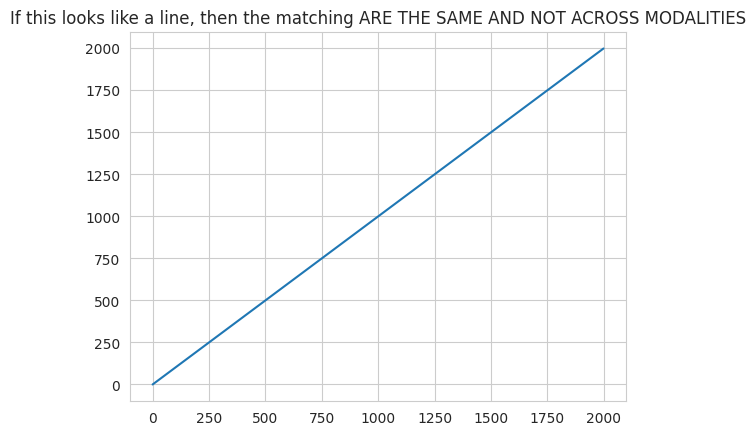

In [12]:
archetype_distances.argmin(axis=1)
plt.plot(archetype_distances.argmin(axis=1))
plt.title('If this looks like a line, then the matching ARE THE SAME AND NOT ACROSS MODALITIES')

In [13]:
sc.pp.pca(adata_prot_subset)
sc.pp.pca(adata_rna_subset)
sc.pp.neighbors(adata_prot_subset,key_added='original_neighbors')
sc.tl.umap(adata_prot_subset,neighbors_key='original_neighbors')
sc.pp.neighbors(adata_rna_subset,key_added='original_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='original_neighbors')

if plot_flag:
    sc.pl.pca(adata_prot_subset,color=['cell_types','major_cell_types'])
    sc.pl.pca(adata_rna_subset,color=['cell_types','major_cell_types'])
    sc.pl.umap(adata_prot_subset,color=['cell_types','major_cell_types'])
    sc.pl.umap(adata_rna_subset,color=['cell_types','major_cell_types'])


In [14]:
if plot_flag:
    adata_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types']=='B cells']
    sc.pp.pca(adata_B_cells)
    sc.pp.neighbors(adata_B_cells, use_rep='X_pca')
    sc.tl.umap(adata_B_cells)
    sc.pl.umap(adata_B_cells, color=['tissue'], title='verifying tissue does not give a major effect')


In [15]:
[len(x) for x in major_to_minor_dict.values()]
major_to_minor_dict

{'CD4 T': ['Activated CD4 T', 'CD4 T', 'ICOS-high Tregs', 'Ifit3-high CD4 T'],
 'B cells': ['B1 B',
  'Ifit3-high B',
  'MZ B',
  'Mature B',
  'Plasma B',
  'Transitional B'],
 'CD8 T': ['CD122+ CD8 T', 'CD8 T', 'Ifit3-high CD8 T'],
 'RBC': ['Erythrocytes'],
 'T cells': ['GD T', 'NKT'],
 'Monocytes': ['Ly6-high mono', 'Ly6-low mono'],
 'Macrophages': ['MZ/Marco-high macrophages', 'Red-pulp macrophages'],
 'cDCs': ['Migratory DCs', 'cDC1s', 'cDC2s'],
 'NK': ['NK'],
 'Neutrophils': ['Neutrophils'],
 'Treg': ['Tregs'],
 'pDCs': ['pDCs']}

In [16]:
# map minor cell types of B cells to diffrene neighboring regions by samplesing from the regions
# and placing the cells in the regions
# make a minor cell type to region dict
adata_prot_subset,horizontal_splits,vertical_splits = add_spatial_data_to_prot(adata_prot_subset, major_to_minor_dict)

In [17]:
if plot_flag:
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], x='X', y='Y', color='cell_types', title='B Cell subtypes locations')
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='T cells-2'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')
    sc.pl.scatter(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='T cells-1'], x='X', y='Y', color='cell_types', title='T Cell subtypes locations')


In [18]:
connectivities = adata_prot_subset.obsp['original_neighbors_connectivities']
connectivities[connectivities>0]=1
assert np.array_equal(np.array([0., 1.], dtype=np.float32), np.unique(np.array(connectivities.todense())))
if plot_flag:
    sns.heatmap(connectivities.todense()[:1000,:1000])

In [19]:
import scipy
neighbor_sums = connectivities.dot(adata_prot_subset.X) # get the sum of all neighbors
# np.array(connectivities.todense()[connectivities.todense()!=0].flatten())
neighbor_means = neighbor_sums/(0.00001+neighbor_sums.sum(1))[:,np.newaxis] # normalize
if plot_flag:
    sns.scatterplot(neighbor_means[:50,:3])
    plt.show()
    plt.scatter(neighbor_means[:50,0],neighbor_means[:50,1])

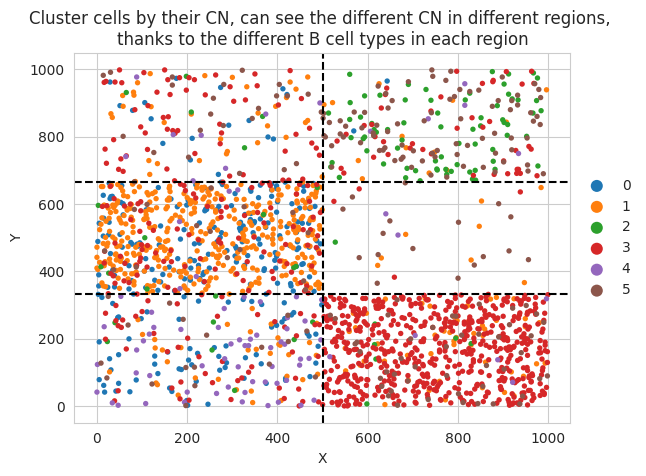

In [20]:
# Standardize the data
normalized_data = zscore(neighbor_means, axis=0)
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(normalized_data)

final_labels = np.array(kmeans.labels_)
if 'CN' in adata_prot_subset.obs:
    adata_rna.obs.drop(columns=['CN'], inplace=True, errors='ignore')
    adata_prot.obs.drop(columns=['CN'], inplace=True, errors='ignore')
adata_prot_subset.obs['CN'] = pd.Categorical(final_labels)
adata_rna_subset.obs['CN'] = pd.Categorical(final_labels)
num_clusters = len(adata_prot_subset.obs['CN'].unique())

palette = sns.color_palette("tab10", num_clusters)  # "tab10" is a good color map, you can choose others too
adata_prot_subset.uns['spatial_clusters_colors'] = palette.as_hex()  # Save as hex color codes
fig, ax = plt.subplots()

sc.pl.scatter(
    adata_prot_subset,
    x='X', y='Y',
    color='CN',
    title='Cluster cells by their CN, can see the different CN in different regions, \nthanks to the different B cell types in each region',
    ax=ax,  # Use the ax created above
    show=False  # Prevent scanpy from showing the plot immediately
)
for x in horizontal_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axvline(x=x, color='black', linestyle='--')

for y in vertical_splits[1:-1]:  # Exclude the edges to avoid border doubling
    ax.axhline(y=y, color='black', linestyle='--')
plt.show()


In [21]:
# sc.pp.neighbors(adata_prot_subset, use_rep='X_neighborhood', key_added='X_neighborhood')
# sc.tl.umap(adata_prot_subset, neighbors_key='X_neighborhood')
# sc.pl.umap(adata_prot_subset, color='CN', title='UMAP of CN vectors colored by CN label')
# sc.pl.umap(adata_prot_subset, color='CN', title='UMAP of CN vectors colored by CN label',neighbors_key='original_neighbors',)
# sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'], color='cell_types', title='UMAP of CN vectors colored by minor cell type label')
adata_prot_subset

AnnData object with n_obs × n_vars = 2000 × 110
    obs: 'batch_indices', 'leiden_subclusters', 'cell_types', 'tissue', 'batch', 'n_genes', 'major_cell_types', 'index_col', 'X', 'Y', 'CN'
    var: 'n_cells'
    uns: 'pca', 'original_neighbors', 'umap', 'spatial_clusters_colors', 'CN_colors'
    obsm: 'archetype_vec', 'X_pca', 'X_umap', 'X_spatial'
    varm: 'PCs'
    obsp: 'original_neighbors_distances', 'original_neighbors_connectivities'

In [22]:
if plot_flag:
    sns.histplot(adata_prot_subset[adata_prot_subset.obs['major_cell_types']=='B cells'].obs, x='cell_types',hue='CN', multiple='fill', stat='proportion')
    # sns.histplot(adata_prot_subset.obs, x='cell_types',hue='CN', multiple='fill', stat='proportion')
    plt.title('Showcasing the signature CN progile of each minor B cell type')

In [23]:
if plot_flag:
    sc.pl.umap(adata_prot_subset, color="cell_types",neighbors_key='original_neighbors',title='Original data minor cell types')
    sc.pl.umap(adata_prot_subset, color="major_cell_types",neighbors_key='original_neighbors',title='Original data major cell types')
    sc.pl.umap(adata_prot_subset[adata_prot_subset.obs['major_cell_types'] =='B cells'], color="cell_types",neighbors_key='original_neighbors',title='Latent space MINOR cell types, B cells only')
    sc.pl.umap(adata_rna_subset, color="CN",neighbors_key='original_neighbors',title='Original RNA data CN')
    sc.pl.umap(adata_prot_subset, color="CN",neighbors_key='original_neighbors',title='Original protein data CN')



In [24]:
# # Define your custom data splitter
# class CustomDataSplitter(scvi.dataloaders.DataSplitter):
#     def __init__(self, adata_manager, *args, **kwargs):
#         super().__init__(adata_manager, *args, **kwargs)
#         self.adata_manager = adata_manager
#         # Calculate sample weights based on label distribution
#         cn_labels = adata_manager.adata.obs["CN"].values  # Replace "CN" with your label column
#         unique_labels, counts = np.unique(cn_labels, return_counts=True)
#         class_weights = {label: 1.0 / count for label, count in zip(unique_labels, counts)}
#         self.sample_weights = torch.tensor([class_weights[cn] for cn in cn_labels], dtype=torch.float)
# 
#     def train_dataloader(self):
#         """Create the train data loader with weighted sampling."""
#         sampler = WeightedRandomSampler(
#             weights=self.sample_weights[self.train_idx],  # Only weights for training samples
#             num_samples=len(self.train_idx),
#             replacement=True
#         )
#         return AnnDataLoader(
#             self.adata_manager,
#             indices=self.train_idx,
#             sampler=sampler,
#             drop_last=False,
#             **self.data_loader_kwargs
#         )


In [25]:
# import numpy as np
# import pandas as pd
# from anndata import AnnData
# 
# def balance_adata_by_duplication(adata, class_key):
#     """
#     Balance the AnnData object by duplicating samples from smaller classes to match the largest class size.
# 
#     Parameters:
#     - adata: AnnData object
#     - class_key: the key in adata.obs that contains the class labels
# 
#     Returns:
#     - new_adata: balanced AnnData object
#     """
#     # Get counts per class
#     class_counts = adata.obs[class_key].value_counts()
#     max_count = class_counts.max()
# 
#     balanced_indices = []
#     for cell_type in class_counts.index:
#         indices = np.where(adata.obs[class_key] == cell_type)[0]
#         n_samples = indices.shape[0]
#         n_to_sample = max_count - n_samples
#         # Sample with replacement to match the max_count
#         if n_to_sample > 0:
#             # Duplicate indices as needed
#             duplicated_indices = np.random.choice(indices, size=n_to_sample, replace=True)
#             all_indices = np.concatenate([indices, duplicated_indices])
#         else:
#             # If already at max count, use the indices as is
#             all_indices = indices
#         balanced_indices.extend(all_indices)
#     # Now create new adata with balanced indices
#     balanced_indices = np.array(balanced_indices)
#     # Shuffle the indices to mix the duplicated samples
#     np.random.shuffle(balanced_indices)
#     new_adata = adata[balanced_indices].copy()
#     # Optionally, add a column indicating whether a sample is original or duplicated
#     new_adata.obs['is_duplicate'] = ['Original' if idx in indices else 'Duplicate' for idx in balanced_indices]
#     return new_adata
# 
# # Usage example:
# # Suppose adata_rna_subset is your AnnData object, and 'CN' is the key in adata.obs that contains the class labels
# 
# balanced_adata = balance_adata_by_duplication(adata_rna_subset, class_key='CN')
# balanced_adata

In [26]:
# save the adata of extrnal processing
# adata_rna_subset = sc.read('adata_rna_subset.hd5ad')
# adata_prot_subset = sc.read('adata_prot_subset.hd5ad')

if 'spatial_clusters_colors' in adata_rna_subset.uns:
    adata_rna_subset.uns['spatial_clusters_colors'] = list(adata_rna_subset.uns['spatial_clusters_colors'])
if 'spatial_clusters_colors' in adata_prot_subset.uns:
    adata_prot_subset.uns['spatial_clusters_colors'] = list(adata_prot_subset.uns['spatial_clusters_colors'])

sc.write('/home/barroz/projects/Mapping-scRNA-seq-Variability-Using-Co-Embedding-to-Understand-Cell-Neighborhood-Effects/CITE-seq_RNA_seq/adata_rna_subset',adata_rna_subset)
sc.write('/home/barroz/projects/Mapping-scRNA-seq-Variability-Using-Co-Embedding-to-Understand-Cell-Neighborhood-Effects/CITE-seq_RNA_seq/adata_prot_subset',adata_prot_subset)


In [27]:
def compute_pairwise_kl(loc, scale):
    batch_size, latent_dim = loc.shape

    # Expand for broadcasting
    loc1 = loc.unsqueeze(1)  # Shape: (256, 1, 10)
    loc2 = loc.unsqueeze(0)  # Shape: (1, 256, 10)

    scale1 = scale.unsqueeze(1)  # Shape: (256, 1, 10)
    scale2 = scale.unsqueeze(0)  # Shape: (1, 256, 10)

    # Compute KL divergence for each pair
    kl_matrix = (
        torch.log(scale2 / scale1) +
        (scale1 ** 2 + (loc1 - loc2) ** 2) / (2 * scale2 ** 2) - 0.5
    ).sum(dim=-1)  # Sum over latent dimensions

    return kl_matrix

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/1:   0%|          | 0/1 [00:00<?, ?it/s]

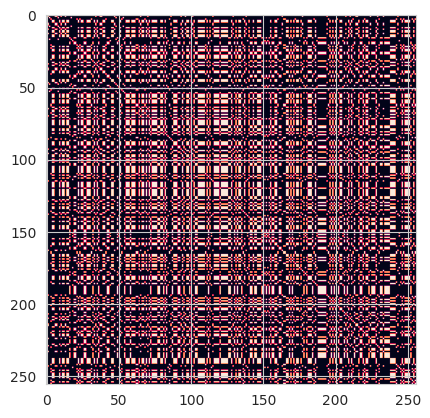

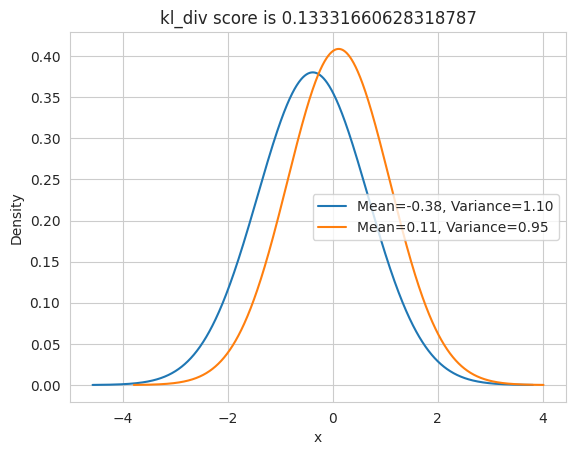

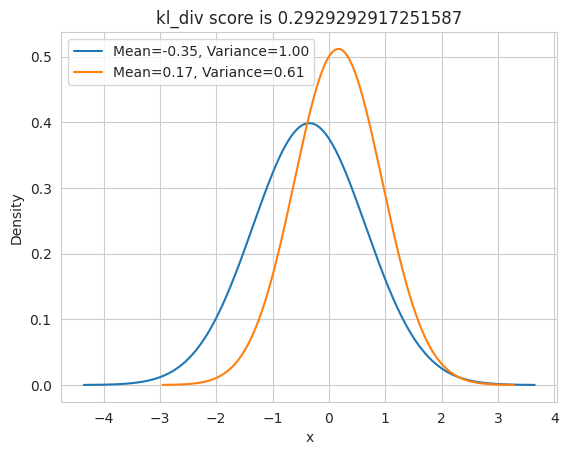

Epoch 1/1: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, v_num=1, train_rna_loss=5.02e+3, train_protein_loss=510, train_contrastive_loss=10.8, train_total_loss=5.78e+3, train_matching_rna_protein_latent_distances=4.95]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 1/1: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it, v_num=1, train_rna_loss=5.02e+3, train_protein_loss=510, train_contrastive_loss=10.8, train_total_loss=5.78e+3, train_matching_rna_protein_latent_distances=4.95]


In [28]:
class DualVAETrainingPlan(TrainingPlan):
    def __init__(self, rna_module, **kwargs):
        protein_vae = kwargs.pop('protein_vae')
        rna_vae_adata = kwargs.pop('rna_vae_adata')
        contrastive_weight = kwargs.pop('contrastive_weight', 1.0)

        # Call super().__init__() after removing custom kwargs
        super().__init__(rna_module, **kwargs)

        # Now assign the attributes
        self.rna_vae_adata = rna_vae_adata
        self.protein_vae = protein_vae
        self.contrastive_weight = contrastive_weight
        self.protein_vae.module = self.protein_vae.module.to(device)
        self.first_step = True
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            list(self.module.parameters()) + list(self.protein_vae.module.parameters()),
            lr=0.001,
            weight_decay=1e-5,
        )
        return optimizer
    def training_step(self, batch, batch_idx):
        # Call the base training step for standard loss computation for RNA VAE
        _, _, rna_loss_output = self.forward(batch)
        protein_batch = self._get_protein_batch(batch)
        _, _, protein_loss_output = self.protein_vae.module.forward(protein_batch)
        rna_inference_outputs = self.module.inference(
            batch["X"], batch_index=batch["batch"], n_samples=1
        )
        index = batch["labels"].detach().cpu().numpy().squeeze()

        rna_latent_embeddings = rna_inference_outputs["z"].squeeze(0)

        protein_inference_outputs = self.protein_vae.module.inference(
            protein_batch["X"], batch_index=protein_batch["batch"], n_samples=1
        )
        kl_div_vec = torch.distributions.kl_divergence(rna_inference_outputs["qz"], protein_inference_outputs["qz"])
        protein_latent_embeddings = protein_inference_outputs["z"].squeeze(0)
        # rna_index = protein_index = index
        # archetype_distances = self.rna_vae_adata.obsm['archetype_distances'][rna_index,:][:, protein_index]
        # rna_locs,protein_locs=np.where(archetype_distances < archetype_distances.mean()*0.3)
        # rna_locs,protein_locs=np.where(archetype_distances < np.percentile(archetype_distances,0.4))
        # for now the archetype distances are already aligned
        matching_rna_protein_latent_distances = torch.norm(rna_latent_embeddings- protein_latent_embeddings, p=2, dim=1).mean()
        # uses the archetype distances to find the matching rna and protein cells
        # the next line assumes that the rna and protein latent embeddings are in the same order
        # matching_rna_protein_latent_distances = torch.norm(rna_latent_embeddings - protein_latent_embeddings, p=2,
        #                                                    dim=1)
        rna_latent_embeddings = rna_inference_outputs["qz"].mean
        protein_latent_embeddings = protein_inference_outputs["qz"].mean

        rna_distances = compute_pairwise_kl(rna_inference_outputs["qz"].loc , rna_inference_outputs["qz"].scale)
        prot_distances = compute_pairwise_kl(protein_inference_outputs["qz"].loc, protein_inference_outputs["qz"].scale)
        # prot_distances = torch.cdist(protein_latent_embeddings, protein_latent_embeddings, p=2)
        # rna_distances = torch.cdist(rna_latent_embeddings, rna_latent_embeddings, p=2)


        # Compute the pairwise KL divergence matrix
                
        # Compute pairwise KL divergence
        if False: # plot histogram of distances prot and rna on top of each other after each epoch
            plt.hist(prot_distances.detach().cpu().numpy().flatten(),bins=100,alpha=0.5)
            plt.hist(rna_distances.detach().cpu().numpy().flatten(),bins=100,alpha=0.5)
            plt.hist(archetype_distances.flatten(), bins=100, alpha=0.5)
            plt.show()
        distances = 0.1 * rna_distances + prot_distances

        # Contrastive loss
        cell_neighborhood_info = torch.tensor(self.rna_vae_adata[index].obs["CN"].values).to(device)
        major_cell_type = torch.tensor(self.rna_vae_adata[index].obs["major_cell_types"].values.codes).to(device).squeeze()

        num_cells = cell_neighborhood_info.shape[0]
        diagonal_mask = torch.eye(num_cells, dtype=torch.bool, device=cell_neighborhood_info.device)
        # this will give us each row represents a item in the array, and each col is whether it is the same as the items in that index of the col
        # this way we get for each cell(a row) which other cells (index of each item in the row, which is the col) are matching
        # so if we got 1,2,1, we will get [[1,0,1],[0,1,0],[1,0,1]]
        same_cn_mask = cell_neighborhood_info.unsqueeze(0) == cell_neighborhood_info.unsqueeze(1)
        same_major_cell_type = major_cell_type.unsqueeze(0) == major_cell_type.unsqueeze(1)
        if self.first_step:  # show the mask only for the first batch to make sure it is working as expected
            self.first_step = False
            plt.imshow(same_cn_mask.cpu().numpy())

            plt.figure()
            plot_torch_normal(rna_inference_outputs["qz"].mean[0][0].item(),rna_inference_outputs["qz"].scale[0][0].item())
            plot_torch_normal(protein_inference_outputs["qz"].mean[0][0].item(),protein_inference_outputs["qz"].scale[0][0].item())
            plt.title(f'kl_div score is {kl_div_vec[0][0].item()}')
            plt.show()
            # plot the second item in the batch
            plt.figure()
            plot_torch_normal(rna_inference_outputs["qz"].mean[1][0].item(),rna_inference_outputs["qz"].scale[1][0].item())
            plot_torch_normal(protein_inference_outputs["qz"].mean[1][0].item(),protein_inference_outputs["qz"].scale[1][0].item())
            plt.title(f'kl_div score is {kl_div_vec[1][0].item()}')
            plt.show()

        distances = distances.masked_fill(diagonal_mask, 0)

        same_major_type_same_cn_mask = (same_major_cell_type * same_cn_mask).type(torch.bool)
        same_major_type_different_cn_mask = (same_major_cell_type * ~same_cn_mask).type(torch.bool)
        different_major_type_same_cn_mask = (~same_major_cell_type * same_cn_mask).type(torch.bool)
        different_major_type_different_cn_mask = (~same_major_cell_type * ~same_cn_mask).type(torch.bool)

        same_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        same_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_same_cn_mask.masked_fill_(diagonal_mask, 0)
        different_major_type_different_cn_mask.masked_fill_(diagonal_mask, 0)

        same_major_type_same_cn_loss = (distances ** 2) * same_major_type_same_cn_mask
        same_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * same_major_type_different_cn_mask
        different_major_type_same_cn_loss = ((10 - distances).clamp(min=0) ** 2) * different_major_type_same_cn_mask
        different_major_type_different_cn_loss = ((10 - distances).clamp(min=0) ** 2) * different_major_type_different_cn_mask
        # for debugging only: # todo remove this same_cn_loss, it is not valid
        same_cn_loss = (distances ** 2) * same_cn_mask
        same_major_type_loss = (distances ** 2) * same_major_cell_type
        # end of debugging

        # positive_loss = (positive_pairs ** 2).mean()
        # negative_loss = ((10 - negative_pairs).clamp(min=0) ** 2).mean()
        # contrastive_loss = positive_loss + negative_loss
        positive_loss = same_major_type_same_cn_loss

        negative_loss = different_major_type_different_cn_loss + different_major_type_same_cn_loss + 2 * same_major_type_different_cn_loss
        cn_loss = (positive_loss.sum() + negative_loss.sum()) / (num_cells * (num_cells - 1))

        total_loss = (rna_loss_output.loss*1+protein_loss_output.loss*1 +
                      self.contrastive_weight * cn_loss+
                      30 * matching_rna_protein_latent_distances.mean())
        # Log losses
        self.log("train_rna_loss", rna_loss_output.loss, prog_bar=True)
        self.log("train_protein_loss", protein_loss_output.loss, prog_bar=True)
        self.log("train_contrastive_loss", cn_loss, prog_bar=True)
        self.log("train_total_loss", total_loss, prog_bar=True)
        self.log("train_matching_rna_protein_latent_distances", matching_rna_protein_latent_distances.mean(), prog_bar=True)
        # print(sum(torch.sum(x) for x in protein_vae.module.parac  q**eters()))
        if self.current_epoch % 50 == 0:
            rna_vae.save(save_dir, prefix=f'batch_{batch_idx}_', save_anndata=False, overwrite=True)
        return total_loss

    def _get_protein_batch(self, batch):
        # Implement logic to fetch the corresponding protein batch
        indices = batch['labels'].detach().cpu().numpy().flatten()  # Assuming batch contains indices
        protein_data = self.protein_vae.adata[indices]
        protein_batch = {
            'X': torch.tensor(protein_data.X.A if issparse(protein_data.X) else protein_data.X).to(device),
            'batch': torch.tensor(protein_data.obs['_scvi_batch'].values, dtype=torch.long).to(device),
        'labels':torch.tensor(protein_data.obs['CN'].values.astype(int)).to(device),
        }
        return protein_batch


SCVI.setup_anndata(
    adata_rna_subset,
    labels_key="index_col",
)

SCVI.setup_anndata(
    adata_prot_subset,
    labels_key="index_col",
)

# Initialize VAEs
rna_vae = scvi.model.SCVI(adata_rna_subset, gene_likelihood="nb", n_hidden=128)
protein_vae = scvi.model.SCVI(adata_prot_subset, gene_likelihood="nb", n_hidden=50)
rna_vae._training_plan_cls = DualVAETrainingPlan

rna_vae.train(
    check_val_every_n_epoch=1,
    max_epochs=1,
    early_stopping=True,
    early_stopping_patience=70,
    early_stopping_monitor="elbo_validation",
    batch_size=256,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae_adata': rna_vae.adata,
                 'contrastive_weight': 10.0,
                 }
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/300:   0%|          | 0/300 [00:00<?, ?it/s]

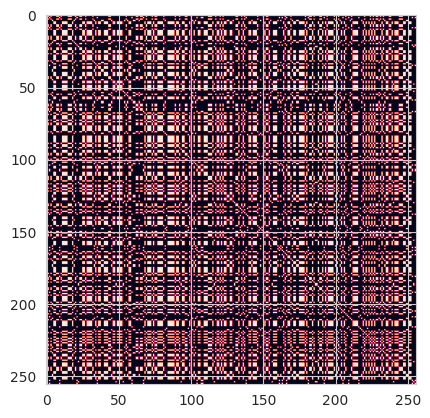

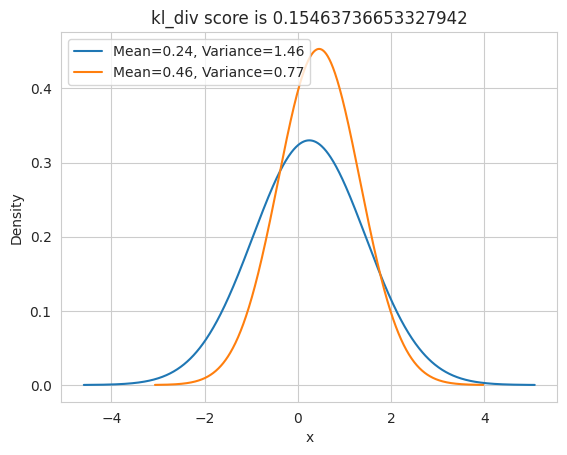

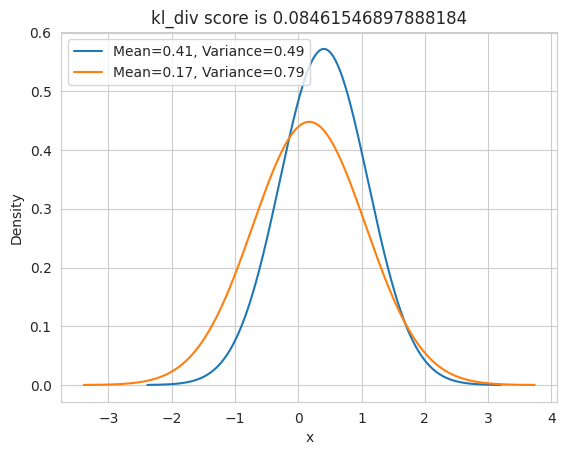

Epoch 300/300: 100%|██████████| 300/300 [01:53<00:00,  2.94it/s, v_num=1, train_rna_loss=3.35e+3, train_protein_loss=312, train_contrastive_loss=0.358, train_total_loss=3.72e+3, train_matching_rna_protein_latent_distances=1.8]   

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 300/300: 100%|██████████| 300/300 [01:53<00:00,  2.64it/s, v_num=1, train_rna_loss=3.35e+3, train_protein_loss=312, train_contrastive_loss=0.358, train_total_loss=3.72e+3, train_matching_rna_protein_latent_distances=1.8]


In [29]:
rna_vae.train(
    check_val_every_n_epoch=1,
    max_epochs=300,
    early_stopping=True,
    early_stopping_patience=70,
    early_stopping_monitor="elbo_validation",
    batch_size=256,
    plan_kwargs={'protein_vae': protein_vae,
                 'rna_vae_adata': rna_vae.adata,
                 'contrastive_weight': 10.0,
                 }
)

In [30]:
# sum(balanced_adata.obs['is_duplicate'] == 'Original')

In [31]:
# Keep only the original samples
# adata_rna_subset = balanced_adata[balanced_adata.obs['is_duplicate'] == 'Original'].copy()


In [32]:
rna_vae.history.keys()

dict_keys(['validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation'])

In [33]:
# Ensure convergence
train_test_results = rna_vae.history["train_total_loss"]
train_test_results["elbo_validation"] = rna_vae.history["elbo_validation"]
train_test_results.iloc[:].plot(logy=True)  # exclude first 10 epochs
plt.show()

KeyError: 'train_total_loss'

In [ ]:
# sc.pp.pca(adata_rna_subset)
# sc.pp.neighbors(adata_rna_subset, use_rep='X_pca',key_added='pca_neighbors')
# sc.tl.umap(adata_rna_subset,neighbors_key='pca_neighbors')
# sc.pl.umap(adata_rna_subset, color="major_cell_types",neighbors_key='X_pca',title='Latent space, major cell types')


In [ ]:
# train_test_results = rna_vae.history["train_total_loss"]
# train_test_results["elbo_validation"] = rna_vae.history["elbo_validation"]
# train_test_results.iloc[:].plot(logy=True)  # exclude first 10 epochs
# plt.show()
SCVI_LATENT_KEY = "X_scVI"
protein_vae.module.to('cpu')
protein_vae.is_trained = True
latent_rna = rna_vae.get_latent_representation()
latent_prot = protein_vae.get_latent_representation()
adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent_rna
adata_prot_subset.obsm[SCVI_LATENT_KEY] = latent_prot

In [ ]:
sc.pp.neighbors(adata_rna_subset, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.pp.neighbors(adata_prot_subset, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='latent_space_neighbors')
sc.tl.umap(adata_prot_subset,neighbors_key='latent_space_neighbors')

# sc.pl.umap(adata_rna_subset, color="major_cell_types",neighbors_key='latent_space_neighbors',title='RNA Latent space, major cell types')
# sc.pl.umap(adata_prot_subset, color="major_cell_types",neighbors_key='latent_space_neighbors',title='Protein Latent space, major cell types')
# minor cell types
# sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] =='B cells'], color="CN",neighbors_key='latent_space_neighbors',title='Latent space, minor cell types (B-cells only) with observed CN')
# make sure that the latent space of the protein and rna are aligned by plotting them on top of each other
sc.pl.umap(adata_rna_subset, color="cell_types", neighbors_key='latent_space_neighbors',
           title='Latent space, minor cell types RNA')
sc.pl.umap(adata_prot_subset, color="cell_types", neighbors_key='latent_space_neighbors',
           title='Latent space, minor cell types Protein')
sc.pl.umap(adata_rna_subset, color="CN", neighbors_key='latent_space_neighbors',
           title='Latent space, CN RNA')
sc.pl.umap(adata_prot_subset, color="CN", neighbors_key='latent_space_neighbors',
              title='Latent space, CN Protein')
# Combine the latent embeddings into one AnnData object before plotting
combined_latent = ad.concat([AnnData(adata_rna_subset.obsm[SCVI_LATENT_KEY]), AnnData(adata_prot_subset.obsm[SCVI_LATENT_KEY])], join='outer', label='modality', keys=['RNA', 'Protein'])

sc.pp.neighbors(combined_latent)
sc.tl.umap(combined_latent)
sc.pl.umap(combined_latent,  color='modality',
           title='Combined Latent space, minor cell types',legend_loc='center')
# plot hist of distances between cells of diffrent modalities in latent space
combined_latent.obs['modality'] = combined_latent.obs['modality'].astype('category')
rna_latent = combined_latent[combined_latent.obs['modality']=='RNA']
rna_latent.obs['major_cell_types'] = adata_rna_subset.obs['major_cell_types'].values
prot_latent = combined_latent[combined_latent.obs['modality']=='Protein']
dis = (np.linalg.norm(rna_latent.X-prot_latent.X,axis=1))
rand_rna_latent = rna_latent.copy()
#  randomize order of cells in rna latent space
shuffled_indices = np.random.permutation(rand_rna_latent.obs.index)
rand_rna_latent = rand_rna_latent[shuffled_indices].copy()
rand_dis = np.linalg.norm(rand_rna_latent.X-prot_latent.X,axis=1)
rand_rna_latent.obs['latent_dis'] = np.log(dis)
sc.pl.umap(rand_rna_latent, cmap='coolwarm',
           color='latent_dis',
           title='Latent space distances between RNA and Protein cells')
plt.show()
rand_rna_latent = rna_latent.copy()
# randomize cell per cell types:
for cell_type in rand_rna_latent.obs['major_cell_types'].unique():
    cell_type_indices = rand_rna_latent.obs['major_cell_types'] == cell_type
    shuffled_indices = np.random.permutation(rand_rna_latent[cell_type_indices].obs.index)
    rand_rna_latent.X[cell_type_indices] = rand_rna_latent[cell_type_indices][shuffled_indices].copy().X
rand_dis_2 = np.linalg.norm(rand_rna_latent.X - prot_latent.X, axis=1)
sns.histplot(rand_dis, bins=100, color='red', label='Randomized distances')
sns.histplot(dis, bins=100, color='blue', label='True distances')
sns.histplot(rand_dis_2, bins=100, color='yellow', label='Randomized distances within cell types')
plt.legend()
plt.show()

In [ ]:
2ff

In [ ]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata_rna_subset.obsm[SCVI_LATENT_KEY] = latent

sc.pp.neighbors(adata_rna_subset, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.tl.umap(adata_rna_subset,neighbors_key='latent_space_neighbors')

sc.pl.umap(adata_rna_subset, color="major_cell_types",neighbors_key='latent_space_neighbors',title='Latent space, major cell types')
sc.pl.umap(adata_rna_subset[adata_rna_subset.obs['major_cell_types'] =='B cells'], color="CN",neighbors_key='latent_space_neighbors',title='Latent space, minor cell types (B-cells only) with observed CN')
# B cells only adta
adata_rna_subset_B_cells = adata_rna_subset[adata_rna_subset.obs['major_cell_types'] == 'B cells']
adata_prot_subset_B_cells = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
sc.pp.neighbors(adata_rna_subset_B_cells, use_rep=SCVI_LATENT_KEY,key_added='latent_space_neighbors')
sc.pp.neighbors(adata_prot_subset_B_cells, use_rep='X_pca',key_added='original_neighbors')
sc.tl.umap(adata_rna_subset_B_cells,neighbors_key='latent_space_neighbors')
sc.tl.umap(adata_prot_subset_B_cells, neighbors_key='original_neighbors')

sc.pl.umap(adata_rna_subset_B_cells, color="cell_types",neighbors_key='latent_space_neighbors',title='Latent space minor cell types (B-cells only)')
sc.pl.umap(adata_prot_subset_B_cells, color="cell_types",
           neighbors_key='original_neighbors', title='Original Latent space MINOR cell types, B cells only')



In [ ]:
adata_2 = adata_prot_subset[adata_prot_subset.obs['major_cell_types'] == 'B cells']
sc.pp.pca(adata_2)
sc.pp.neighbors(adata_2, use_rep='X_pca')
sc.tl.umap(adata_2)
sc.pl.umap(adata_2, color='cell_types')


In [ ]:
silhouette_score_per_cell_type_original= {}
silhouette_score_per_cell_type_latent = {}
silhouette_score_per_cell_type= {}
cell_type_indexes = adata_rna_subset.obs['major_cell_types'] == 'B cells'
cell_type_data = adata_rna_subset[cell_type_indexes].X
minor_cell_type_lables =  adata_rna_subset[cell_type_indexes].obs['cell_types']
curr_latent = adata_rna_subset.obsm[SCVI_LATENT_KEY][cell_type_indexes]

silhouette_score_per_cell_type['original_B cells'] = silhouette_score(cell_type_data, minor_cell_type_lables)
silhouette_score_per_cell_type['Ours B cells'] = silhouette_score(curr_latent, minor_cell_type_lables)

In [ ]:
adata_rna_subset[cell_type_indexes].obs['cell_types']

In [ ]:
# plot as box plot
plt.bar(silhouette_score_per_cell_type.keys(), silhouette_score_per_cell_type.values())

In [ ]:
adata_rna_subset.obsm[SCVI_LATENT_KEY]


In [ ]:
major_to_minor_dict